In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

ml_df = yf.download('^GSPC', start="1978-01-01", interval="1d")

for i in [1, 2, 3, 5, 7, 14, 21]:
    ml_df[f'Close_{i}_Value'] = ml_df['Adj Close'].pct_change(i)
    ml_df[f'Volume_{i}_Value'] = ml_df['Volume'].pct_change(i)
ml_df.dropna(inplace=True)
for i in [3, 7, 14, 21]:
    ml_df[f'Volt_{i}_Value'] = np.log(1 + ml_df['Close_1_Value']).rolling(i).std()
ml_df.dropna(inplace=True)  

sp500_regimes = pd.read_csv('../data/sp500_regimes.csv')
sp500_regimes.set_index('Date', inplace=True)
sp500_regimes.index = pd.to_datetime(sp500_regimes.index)
ml_df.index = pd.to_datetime(ml_df.index)
data = pd.merge(ml_df.drop(columns=['High','Low','Open','Close','Adj Close']), sp500_regimes, on='Date',how='inner')
data.to_csv('../data/sp500_backtest_regime_for_preprocessing.csv')
data['color'] = data['color'].shift(-1)
data.dropna(inplace=True)

/Users/alden/quantfin/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


FileNotFoundError: [Errno 2] No such file or directory: 'sp500_regimes.csv'

In [ ]:
X = data.drop(columns=['color'])
y = data['color']

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Counter(y_train)

Counter({0: 5925, 1: 938, 3: 933, 2: 729})

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Assuming X is your dataset and y is the target variable
oversampler = SMOTE()  # Choose your oversampler: RandomOverSampler, SMOTE, or ADASYN
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [2]:
Counter(y_resampled)

NameError: name 'Counter' is not defined

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42, learning_rate=0.3947905167925872, max_depth= int(5.628094190643376), n_estimators= int(845.8637582367364))
model.fit(X_resampled, y_resampled)

NameError: name 'X_resampled' is not defined

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' if you have a multi-class problem
print(f'F1 Score: {f1}')
y_prob_pred = model.predict_proba(X_test)
acc_score = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_prob_pred, multi_class='ovr')
print(f'AUC-ROC (One-vs-Rest): {auc_roc}')

Accuracy: 98.45%
F1 Score: 0.9846096787891574
AUC-ROC (One-vs-Rest): 0.9983646689581716


In [ ]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def xgb_cv(max_depth,  learning_rate,n_estimators):
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=4,max_depth=int(max_depth), learning_rate=learning_rate,n_estimators=int(n_estimators), random_state=42)
    return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

param_bounds = {'max_depth': (4, 10), 'learning_rate':(0.01,1), 'n_estimators': (100,1000)}

optimizer = BayesianOptimization(f=xgb_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=30, n_iter=30)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.9942    | 0.3808    | 9.704     | 758.8     |
| 2         | 0.9945    | 0.6027    | 4.936     | 240.4     |
| 3         | 0.994     | 0.0675    | 9.197     | 641.0     |
| 4         | 0.9946    | 0.711     | 4.124     | 972.9     |
| 5         | 0.9939    | 0.8341    | 5.274     | 263.6     |
| 6         | 0.9945    | 0.1916    | 5.825     | 572.3     |
| 7         | 0.9944    | 0.4376    | 5.747     | 650.7     |
| 8         | 0.9942    | 0.1481    | 5.753     | 429.7     |
| 9         | 0.9938    | 0.4615    | 8.711     | 279.7     |
| 10        | 0.9936    | 0.5191    | 7.554     | 141.8     |
| 11        | 0.9945    | 0.6115    | 5.023     | 158.5     |
| 12        | 0.9937    | 0.9494    | 9.794     | 827.6     |
| 13        | 0.9946    | 0.3116    | 4.586     | 715.8     |
| 14        | 0.995     | 0.4458    | 4.732     | 545.7     |
| 15    

In [100]:
print(optimizer.max)

{'target': 0.9950788042012668, 'params': {'learning_rate': 0.3947905167925872, 'max_depth': 5.628094190643376, 'n_estimators': 845.8637582367364}}


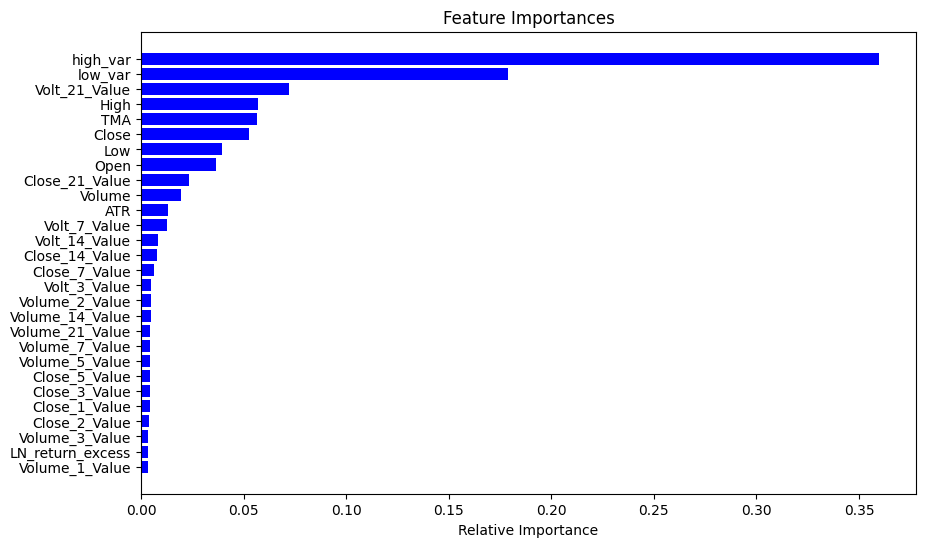

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = model.feature_importances_

# Get the indices sorted by importance
indices = np.argsort(importances)

# Get the feature names
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Confusion Matrix:
[[1452    8    1    1]
 [   6  233    0    3]
 [   3    0  181    5]
 [   0    2    1  236]]


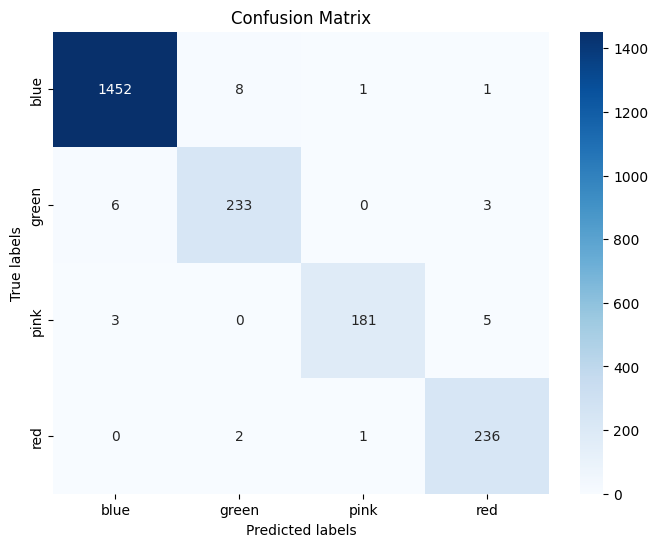

In [123]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred = encoder.inverse_transform(y_pred)
y_test = encoder.inverse_transform(y_test)
labels = np.unique(y_pred)


# Compute the confusion matrix with labels
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Accuracy: 98.45%
F1 Score: 0.9846096787891574
AUC-ROC (One-vs-Rest): 0.9981618130787344


## save the model

In [78]:
# Assuming model is your trained XGBRegressor model
model.save_model('../model/xgboost_model.json')